# Logistic regression

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../Data/Default.csv")
df.head()


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [3]:
df.describe().T.drop("count", axis=1)


,mean,std,min,25%,50%,75%,max
balance,835.374886,483.714985,0.000000,481.731105,823.636973,1166.308386,2654.322576
income,33516.981876,13336.639563,771.967729,21340.462903,34552.644802,43807.729272,73554.233495


In [4]:
df["default"].value_counts()  # unbalanced dataset


default
No     9667
Yes     333
Name: count, dtype: int64

In [5]:
df["student"].value_counts()


student
No     7056
Yes    2944
Name: count, dtype: int64

<Axes: xlabel='balance', ylabel='income'>

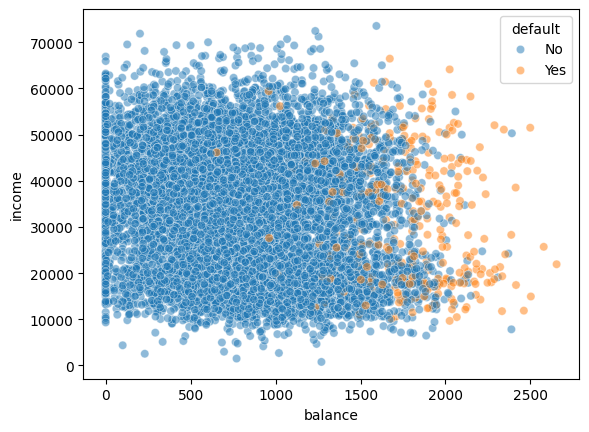

In [6]:
sns.scatterplot(data=df, x="balance", y="income", hue="default", alpha=0.5)


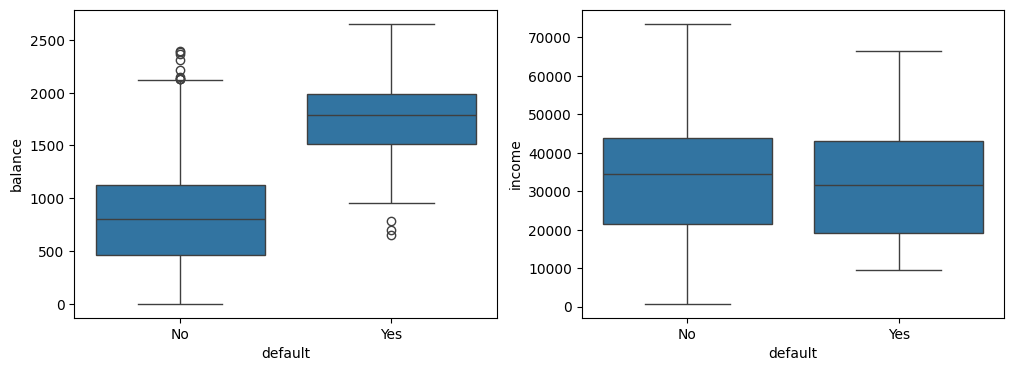

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax, column in zip(ax, ["balance", "income"]):
    sns.boxplot(data=df, x="default", y=column, ax=ax)

# TODO: for reader: clean up outliers


## Dummy encode categorical variables

In [8]:
# one hot encoding
pd.get_dummies(df, columns=["default", "student"]).head()


,balance,income,default_No,default_Yes,student_No,student_Yes
0,729.526495,44361.625074,True,False,True,False
1,817.180407,12106.134700,True,False,False,True
2,1073.549164,31767.138947,True,False,True,False
3,529.250605,35704.493935,True,False,True,False
4,785.655883,38463.495879,True,False,True,False


In [9]:
# dummy encoding
df = pd.get_dummies(df, columns=["default", "student"], drop_first=True)
df.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,False,False
1,817.180407,12106.134700,False,True
2,1073.549164,31767.138947,False,False
3,529.250605,35704.493935,False,False
4,785.655883,38463.495879,False,False


## Logistic function

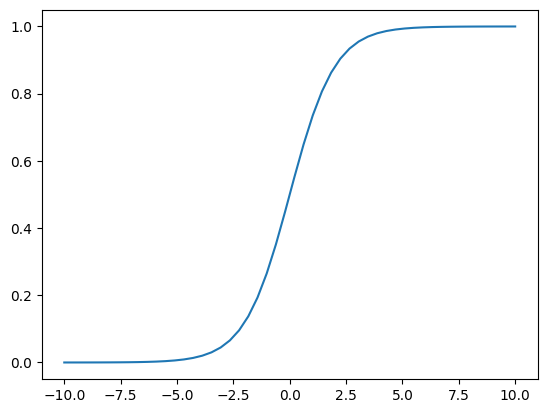

In [10]:
logistic_function = lambda x: np.exp(x)/(1+np.exp(x)) # beta_0 = 0, beta_1 = 1
x = np.linspace(-10,10)
plt.plot(x, logistic_function(x)) # S-shaped curve

## Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df.drop("default_Yes", axis = 1), df["default_Yes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

X_train.shape, X_test.shape

((6700, 3), (3300, 3))

In [12]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_test.mean(), scaled_X_test.std(), scaled_X_train.mean(), scaled_X_train.std() 

(-0.005467573543403287, 0.9870951848219804, 7.74173428514736e-17, 1.0)

In [13]:
model = LogisticRegression(penalty = None)
model.fit(scaled_X_train,  y_train) # estimated beta parameters
model.coef_, model.intercept_

(array([[ 2.888348  ,  0.00687543, -0.28952422]]), array([-6.36240853]))

## Make sample prediction

In [14]:
# not scaled
test_sample = pd.DataFrame(
    {"balance": [1500, 1500], "income": [40000, 40000], "student_Yes": [1, 0]}
)

test_sample



,balance,income,student_Yes
0,1500,40000,1
1,1500,40000,0


In [15]:
scaled_test_sample = scaler.transform(test_sample)
scaled_test_sample

array([[ 1.37268368,  0.47593334,  1.54286221],
       [ 1.37268368,  0.47593334, -0.64814602]])

In [16]:
model.predict_proba(scaled_test_sample)
# sample1: probability not default 0.944, prob default 0.055

array([[0.94485389, 0.05514611],
       [0.90084904, 0.09915096]])

In [17]:
model.predict_proba(scaled_test_sample).sum(axis=1)

array([1., 1.])

## Predict on all test data

In [18]:
y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_probability

array([[9.30448543e-01, 6.95514567e-02],
       [9.98551323e-01, 1.44867725e-03],
       [9.99985411e-01, 1.45887899e-05],
       ...,
       [9.99735713e-01, 2.64287223e-04],
       [2.67515259e-01, 7.32484741e-01],
       [9.97656416e-01, 2.34358391e-03]])

In [19]:
y_pred = model.predict(scaled_X_test)
y_pred

array([False, False, False, ..., False,  True, False])

In [20]:
y_pred.sum()

46

In [21]:
threshold = 0.5 # change threshold based on application needs - talk to domain expert

# predicted default_Yes
y_pred = (y_pred_probability > threshold)[:,1]*1

In [22]:
y_pred.sum()

46

## Evaluation

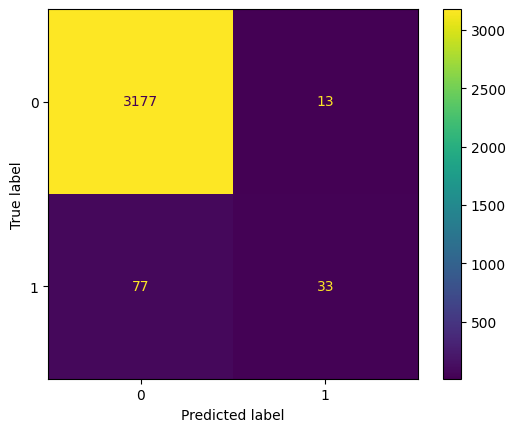

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm)

display.plot();

In [24]:
TP = 33
TN = 3177
FP = 13
FN = 77

accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

accuracy, recall, precision, f1

(0.9727272727272728, 0.3, 0.717391304347826, 0.4230769230769231)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3190
        True       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300

